In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time

import generated_images
import dataset_loader
import curves
import analysis
from processor import FractalImageProcessor

/home/jknyspel/Documents/Code/fractal-prefix-image-format/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 1/3680 images


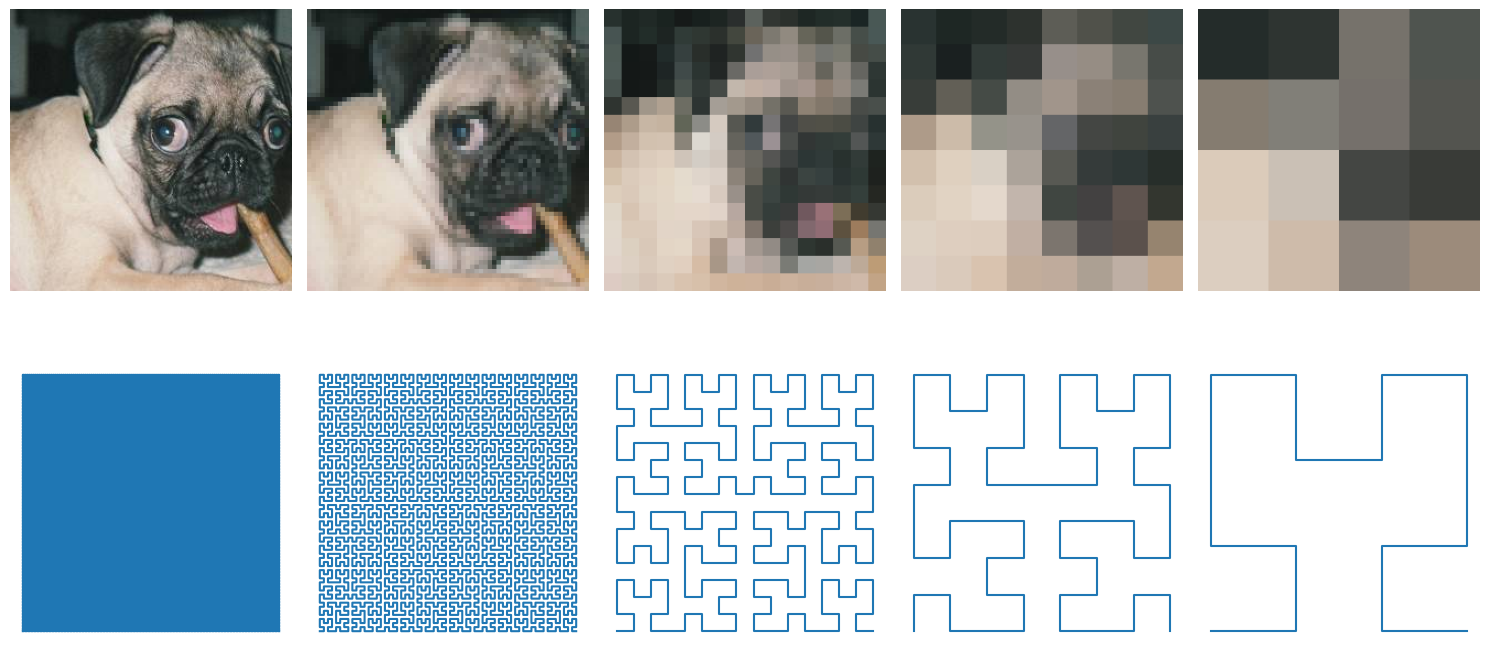

In [2]:
example_curve = curves.HilbertCurve()
processor = FractalImageProcessor(example_curve, mipmap_strategy="average")

size = 256
example_image = dataset_loader.load_images(1, random_seed=45)[0]
example_image = example_image[:size, :size, ...]

encoded, metadata = processor.encode(example_image)

orders = [8, 6, 4, 3, 2]
_, ax = plt.subplots(2, len(orders), figsize=(15, 8))
for i, order in enumerate(orders):
    max_order = np.ceil(np.log2(size))
    prefix_ratio = 0.25 ** (max_order - order)
    ax[0, i].imshow(processor.decode(encoded, metadata, prefix_ratio))
    ax[0, i].axis('off')
    
    t = list(range(4 ** order))
    x = [example_curve.d_to_xy(value, order)[0] for value in t]
    y = [example_curve.d_to_xy(value, order)[1] for value in t]
    ax[1, i].plot(x, y)
    ax[1, i].set_aspect('equal')
    ax[1, i].axis('off')
    
plt.tight_layout()
plt.show()

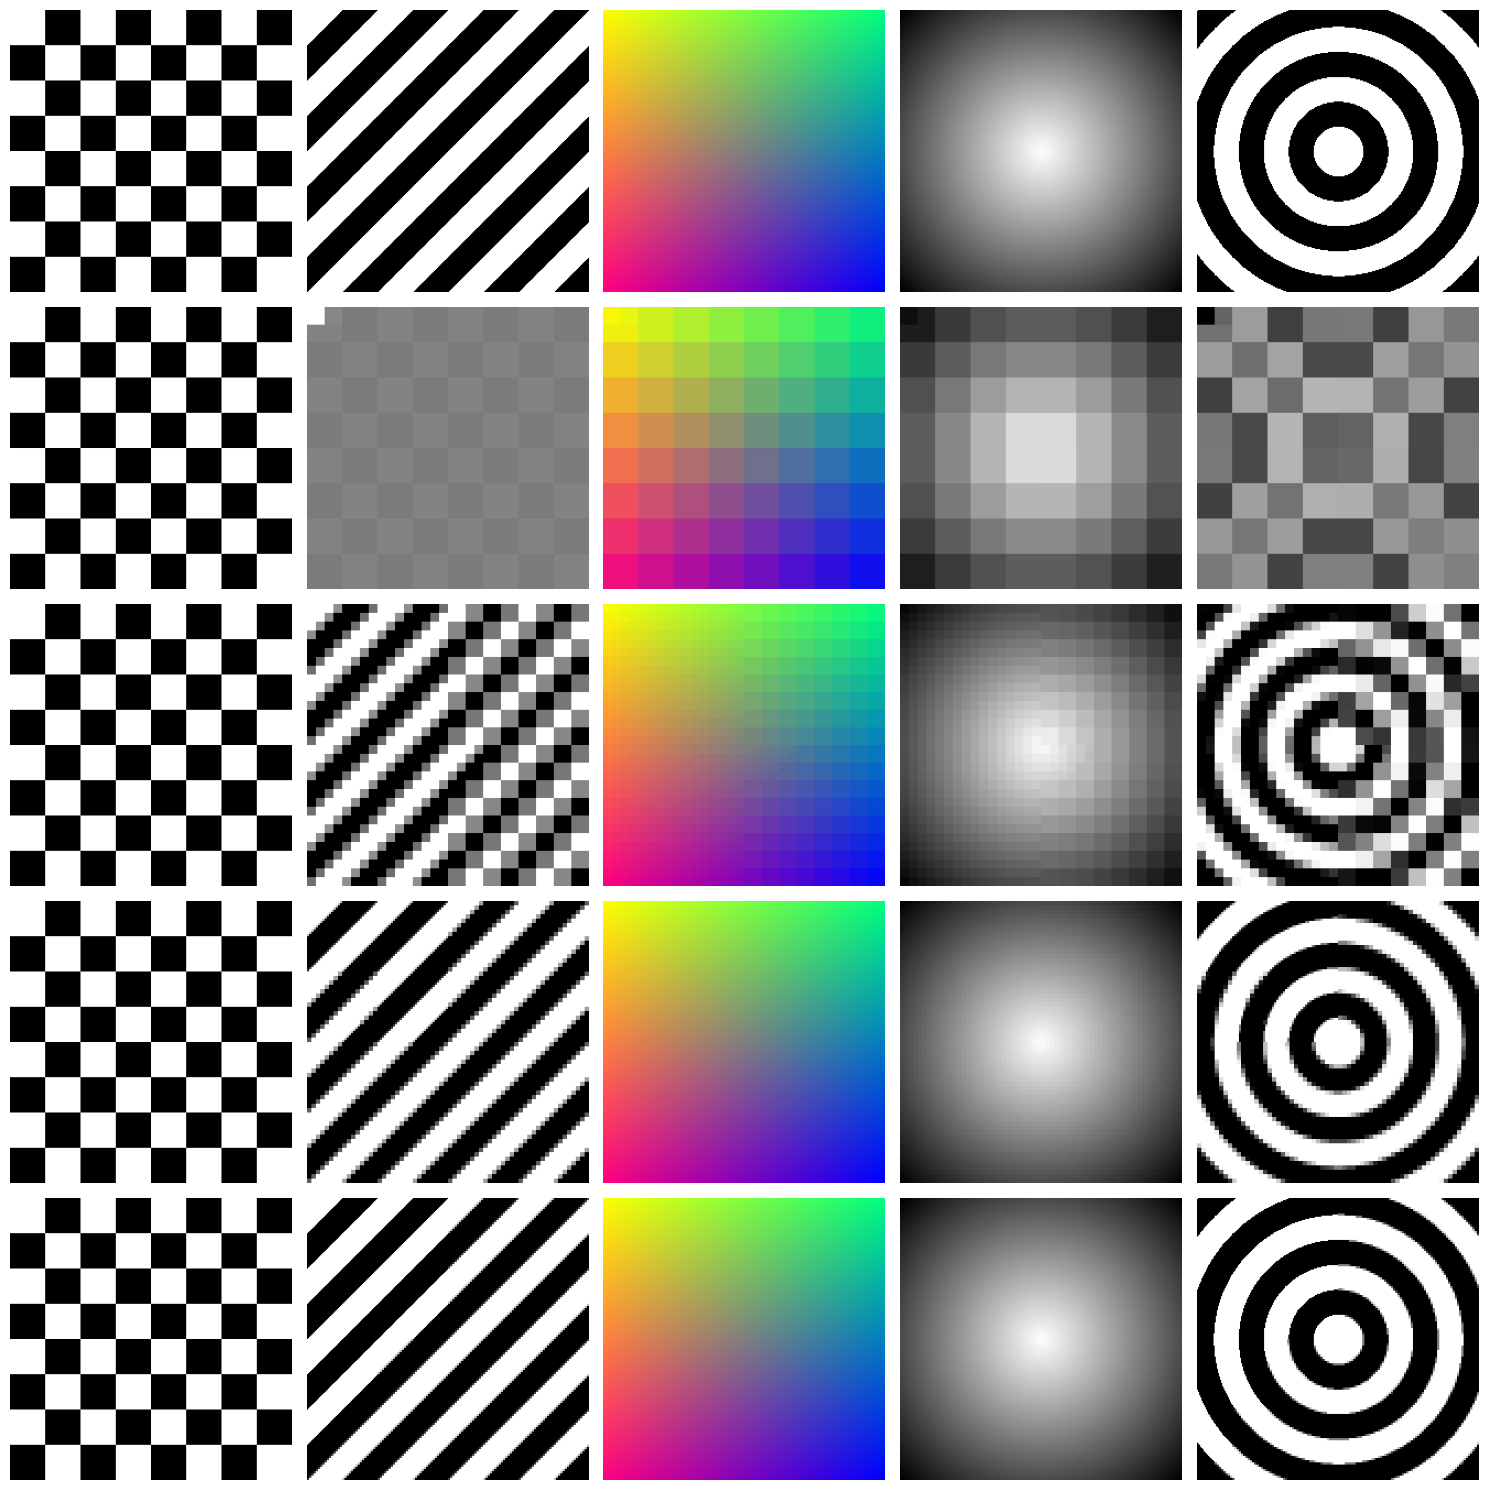

In [3]:
processor = FractalImageProcessor(curves.HilbertCurve(), mipmap_strategy="average")
prefix_lengths = [0.001, 0.01, 0.1, 0.5]
example_generated_images = [
    generated_images.checkerboard(256), 
    generated_images.diagonal_stripes(256), 
    generated_images.color_gradient(256), 
    generated_images.radial_gradient(256),
    generated_images.concentric_circles(256)]

_, ax = plt.subplots(len(prefix_lengths)+1, len(example_generated_images), figsize=(15, 15))
for i, image in enumerate(example_generated_images):
    ax[0, i].imshow(image)
    ax[0, i].axis('off')

    encoded, metadata = processor.encode(image)

    for j, prefix_length in enumerate(prefix_lengths):
        decoded = processor.decode(encoded, metadata, prefix_length)
        ax[j + 1, i].imshow(decoded)
        ax[j + 1, i].axis('off')

plt.tight_layout()
plt.show()

Loaded 5/3680 images


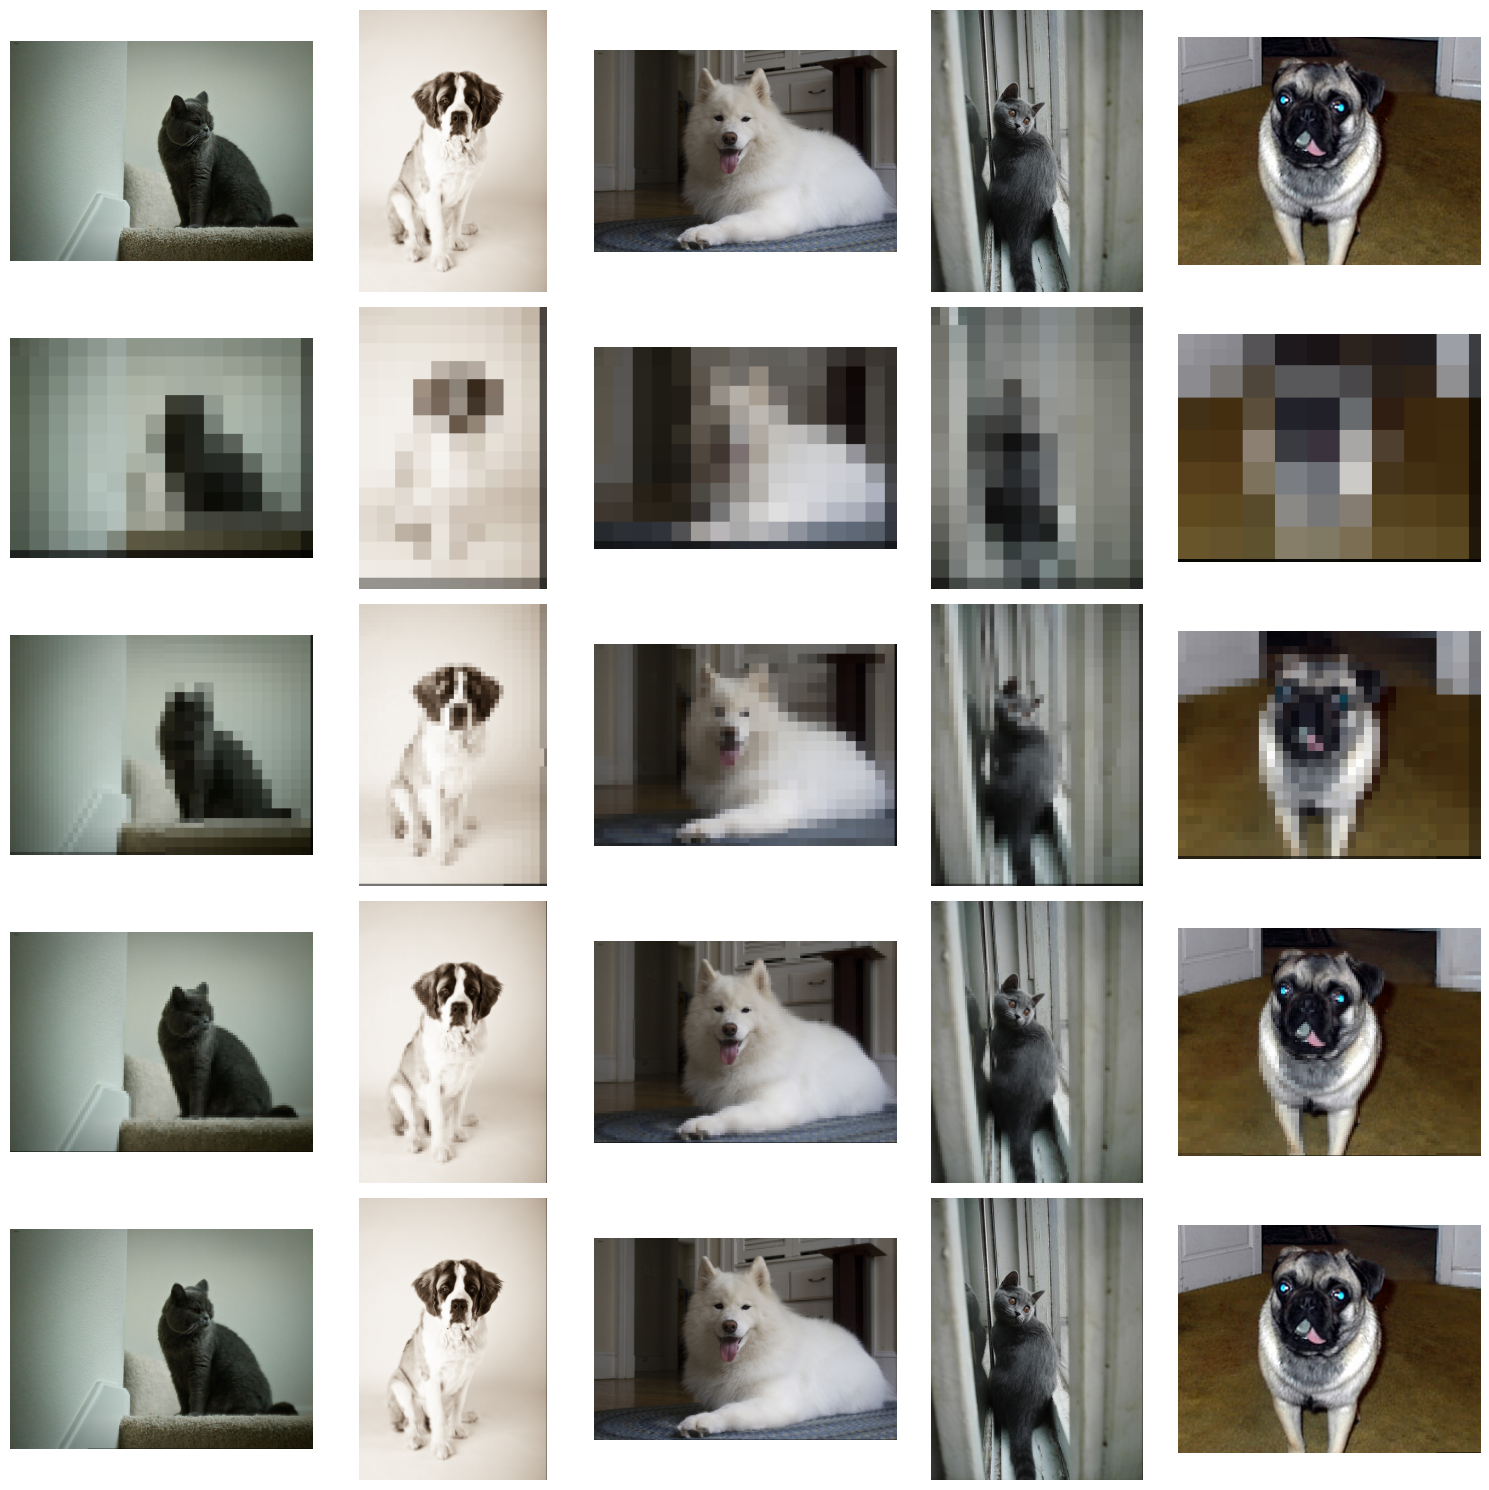

In [4]:

prefix_lengths = [0.001, 0.01, 0.1, 0.5]
example_dataset_images = dataset_loader.load_images(5, random_seed=123)
processor = FractalImageProcessor(curves.HilbertCurve(), mipmap_strategy="average")

_, ax = plt.subplots(len(prefix_lengths)+1, len(example_dataset_images), figsize=(15, 15))
for i, image in enumerate(example_dataset_images):
    ax[0, i].imshow(image)
    ax[0, i].axis('off')

    encoded, metadata = processor.encode(image)

    for j, prefix_length in enumerate(prefix_lengths):
        decoded = processor.decode(encoded, metadata, prefix_length)
        ax[j + 1, i].imshow(decoded)
        ax[j + 1, i].axis('off')

plt.tight_layout()
plt.show()

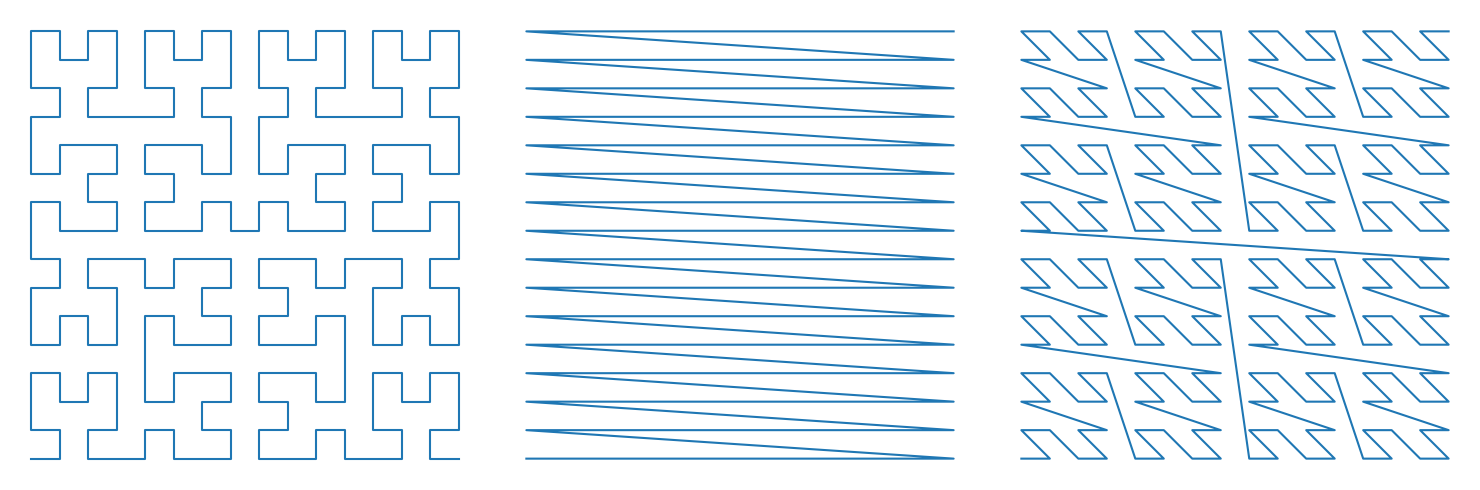

In [5]:
implemented_curves = [curves.HilbertCurve(), curves.ScanlineCurve(), curves.ZOrderCurve()]

_, ax = plt.subplots(1, len(implemented_curves), figsize=(15, 5))
for i, curve in enumerate(implemented_curves):
    order = 4
    t = list(range(4 ** order))
    x = [curve.d_to_xy(value, order)[0] for value in t]
    y = [curve.d_to_xy(value, order)[1] for value in t]
    ax[i].plot(x, y)
    ax[i].set_aspect('equal')
    ax[i].axis('off')

plt.tight_layout()
plt.show()

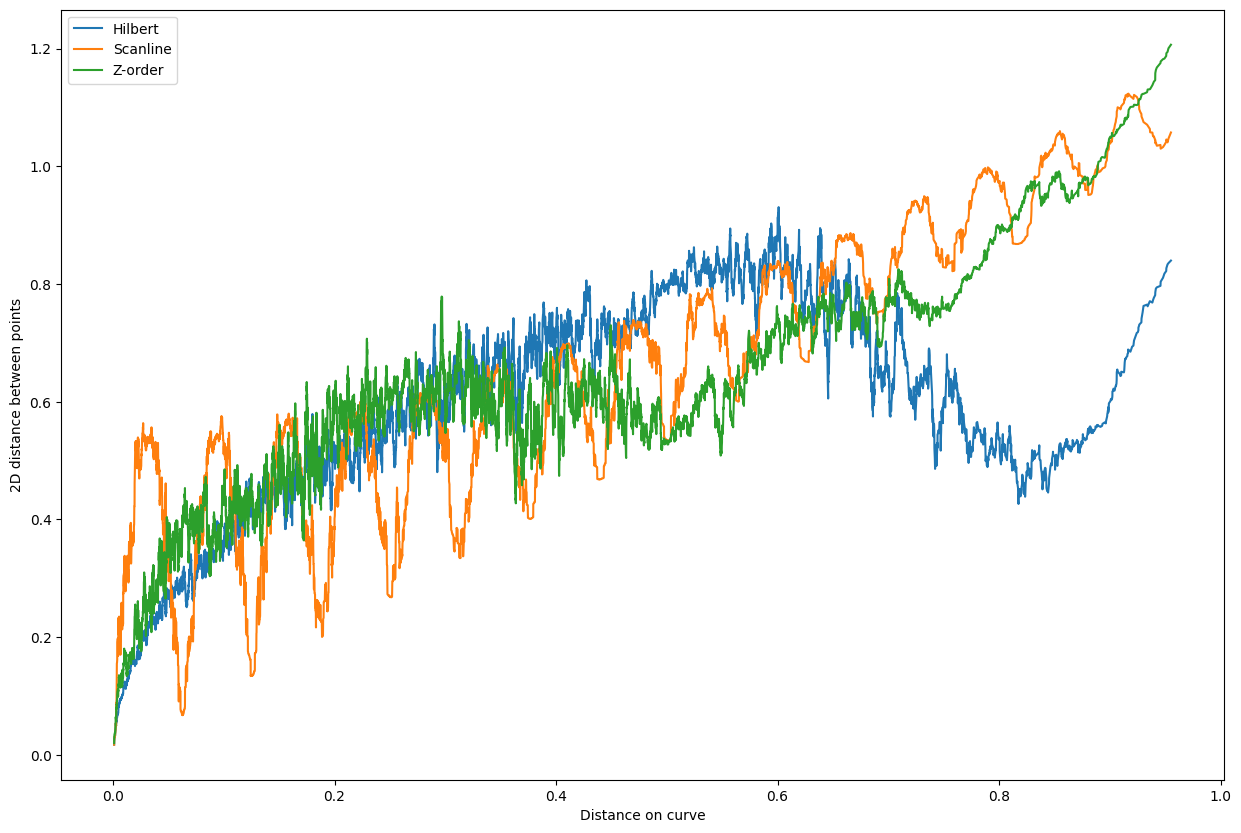

Hilbert:     6.0432e-01
Scanline:    6.7680e-01
Z-order:     6.7197e-01


In [6]:
curves_by_name = {
    'Hilbert': curves.HilbertCurve(), 
    'Scanline': curves.ScanlineCurve(), 
    'Z-order': curves.ZOrderCurve()
}

curve_localities = {}
for name, curve in curves_by_name.items():
    order = 4
    dt, dxy = analysis.calculate_curve_locality(curve, order, n_samples=5000, seed=123)
    curve_localities[name] = (dt, dxy)

_, ax = plt.subplots(1, 1, figsize=(15, 10))
for name, (dt, dxy) in curve_localities.items():
    smoothing_window = 15
    smoothed_dxy = np.convolve(dxy, np.ones(smoothing_window*2+1)/(smoothing_window*2+1), mode='valid')
    ax.plot(dt[smoothing_window:-smoothing_window], smoothed_dxy, label=name)

ax.set_xlabel("Distance on curve")
ax.set_ylabel("2D distance between points")
ax.legend()
plt.show()

curve_localities_auc = {}
for name, (dt, dxy) in curve_localities.items():
    curve_localities_auc[name] = analysis.area_under_curve(dxy, dt)

for name, auc in curve_localities_auc.items():
    print(f"{(f"{name}:"):<12} {auc:0.4e}")
    
pickle.dump(curve_localities, open(f"results/curve_localities_{time.time()}.pkl", "wb"))

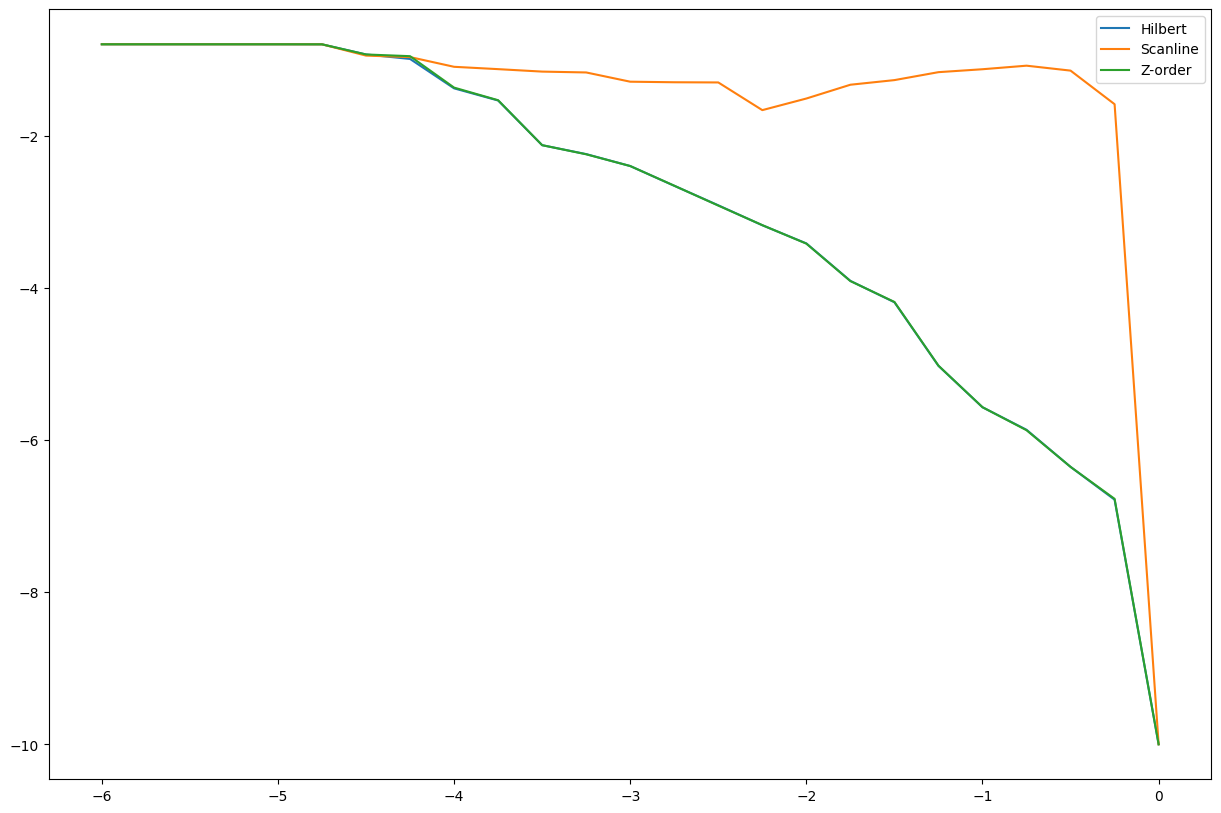

Hilbert:     2.7112e-03
Scanline:    2.1147e-01
Z-order:     2.7151e-03


In [ ]:
generated_test_images = generated_images.random_images(10, size=256, seed=123)

curves_to_test = {
    'Hilbert': curves.HilbertCurve(), 
    'Scanline': curves.ScanlineCurve(), 
    'Z-order': curves.ZOrderCurve()
}

prefix_lengths = np.logspace(np.log10(1e-6), np.log10(1-1e-6), 25)

generated_images_results = {}
for curve_name, curve in curves_to_test.items():
    processor = FractalImageProcessor(curve, mipmap_strategy="average")
    generated_images_results[curve_name] = analysis.calculate_error_curve(processor, generated_test_images, prefix_lengths)

_, ax = plt.subplots(1, 1, figsize=(15, 10))
for curve_name, result in generated_images_results.items():
    ax.plot(np.log10(prefix_lengths), np.log([max(v, np.exp(-10)) for v in result]), label=curve_name)

ax.set_xlabel("log_10(prefix length)")
ax.set_ylabel("log(error)")
ax.legend()
plt.show()

areas = {name: analysis.area_under_curve(result, prefix_lengths) for name, result in generated_images_results.items()}
for name, area in areas.items():
    print(f"{(f"{name}:"):<12} {area:0.4e}")
    
pickle.dump(generated_images_results, open(f"results/generated_images_results_{time.time()}.pkl", "wb"))

Loaded 5/3680 images


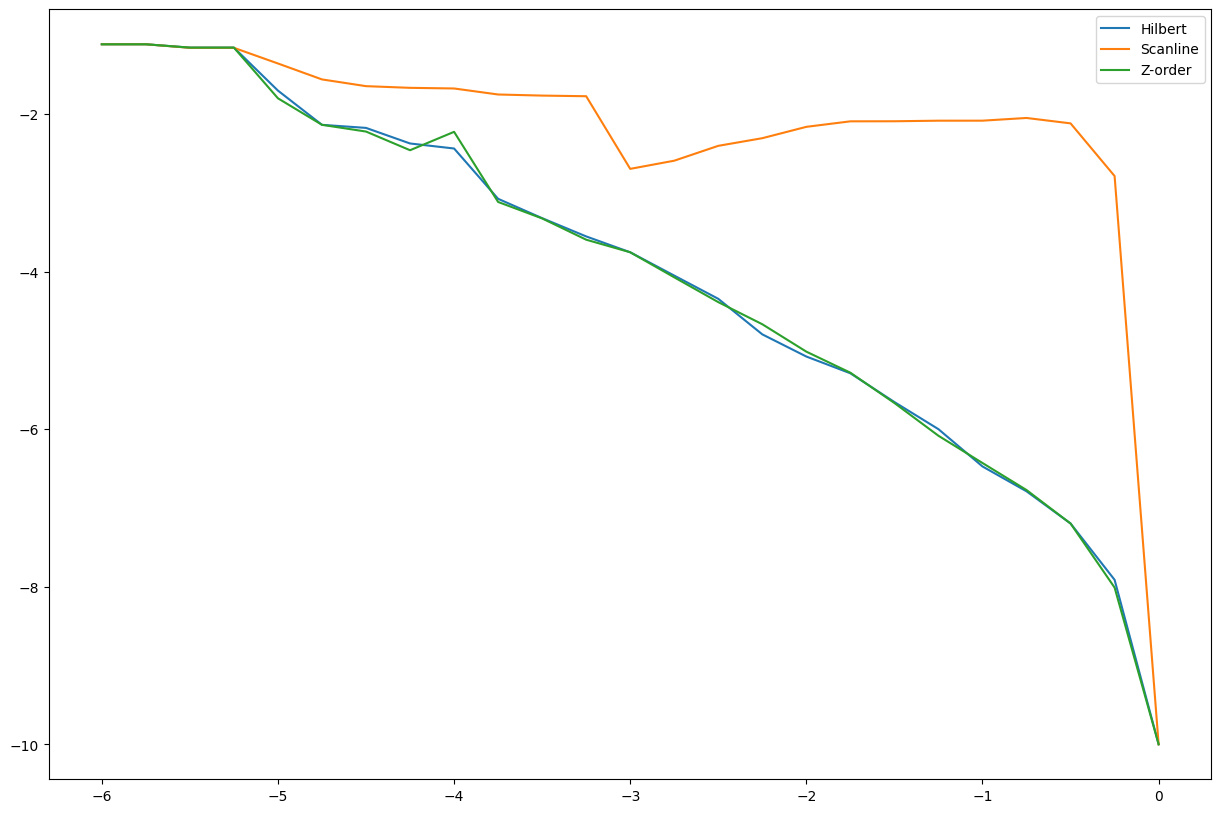

Hilbert:     8.5326e-04
Scanline:    7.5298e-02
Z-order:     8.4552e-04


In [ ]:
dataset_images = dataset_loader.load_images(5, random_seed=123)

curves_to_test = {
    'Hilbert': curves.HilbertCurve(), 
    'Scanline': curves.ScanlineCurve(), 
    'Z-order': curves.ZOrderCurve()
}

prefix_lengths = np.logspace(np.log10(1e-6), np.log10(1-1e-6), 25)

dataset_images_results = {}
for curve_name, curve in curves_to_test.items():
    processor = FractalImageProcessor(curve, mipmap_strategy="average")
    dataset_images_results[curve_name] = analysis.calculate_error_curve(processor, dataset_images, prefix_lengths)

_, ax = plt.subplots(1, 1, figsize=(15, 10))
for curve_name, result in dataset_images_results.items():
    ax.plot(np.log10(prefix_lengths), np.log([max(v, np.exp(-10)) for v in result]), label=curve_name)

ax.set_xlabel("log_10(prefix length)")
ax.set_ylabel("log(error)")
ax.legend()
plt.show()

areas = {name: analysis.area_under_curve(result, prefix_lengths) for name, result in dataset_images_results.items()}
for name, area in areas.items():
    print(f"{(f"{name}:"):<12} {area:0.4e}")
    
pickle.dump(generated_images_results, open(f"results/dataset_images_results_{time.time()}.pkl", "wb"))